In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import glob
import requests
import io

pd.options.display.max_columns=100

# Manufacturer and User Facility Device Experience Database - (MAUDE)

https://www.fda.gov/medical-devices/mandatory-reporting-requirements-manufacturers-importers-and-device-user-facilities/manufacturer-and-user-facility-device-experience-database-maude

* http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2017.zip
* http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2018.zip
* http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2019.zip

In [2]:
urls = [
        'http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2017.zip',
        'http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2018.zip',
        'http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2019.zip'
       ]

In [113]:
# DataFrame to store the MAUDE Data

def maude_downloader(urls):
    df = pd.DataFrame()
    # Relevant urls to download
    for url in urls:
        # Making the download request
        file = requests.get(url)
        # Accessing the file in the zip.
        with zipfile.ZipFile(io.BytesIO(file.content)) as zf:
            # Reading the filename
            for name in zf.namelist():
                # Opening the file, decoding and parsing for DataFrame
                # Skips over rows with errors.
                with zf.open(name) as myfile:
                    df = df.append(pd.read_csv(io.StringIO(myfile.read().decode('latin1')), delimiter='|', 
                                               error_bad_lines=False, warn_bad_lines=False))
    return df

In [28]:
foidev = maude_downloader(urls)

b'Skipping line 402493: expected 28 fields, saw 29\n'
b'Skipping line 527961: expected 28 fields, saw 29\nSkipping line 543277: expected 28 fields, saw 29\n'
b'Skipping line 645028: expected 28 fields, saw 29\n'
b'Skipping line 698366: expected 28 fields, saw 29\n'
b'Skipping line 731904: expected 28 fields, saw 29\nSkipping line 741846: expected 28 fields, saw 29\n'
b'Skipping line 810062: expected 28 fields, saw 30\n'
b'Skipping line 4369: expected 28 fields, saw 30\n'
b'Skipping line 189783: expected 28 fields, saw 29\n'
b'Skipping line 199166: expected 28 fields, saw 29\n'
b'Skipping line 254063: expected 28 fields, saw 29\n'
b'Skipping line 276894: expected 28 fields, saw 29\n'
b'Skipping line 299627: expected 28 fields, saw 29\nSkipping line 319159: expected 28 fields, saw 29\nSkipping line 324009: expected 28 fields, saw 29\n'
b'Skipping line 389388: expected 28 fields, saw 29\nSkipping line 389743: expected 28 fields, saw 29\n'
b'Skipping line 406383: expected 28 fields, saw 29

In [29]:
mdrfoi_urls = ['http://www.accessdata.fda.gov/MAUDE/ftparea/mdrfoi.zip', 'http://www.accessdata.fda.gov/MAUDE/ftparea/mdrfoithru2019.zip']
mdrfoi = maude_downloader(mdrfoi_urls)

/home/wolfgang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (13,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
b'Skipping line 3753393: expected 77 fields, saw 105\n'
b'Skipping line 7763075: expected 77 fields, saw 78\n'
b'Skipping line 7791742: expected 77 fields, saw 78\n'
b'Skipping line 7812613: expected 77 fields, saw 78\n'
/home/wolfgang/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (0,1,5,12,13,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,74) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [30]:
patient_urls = ['http://www.accessdata.fda.gov/MAUDE/ftparea/patientthru2019.zip', 'http://www.accessdata.fda.gov/MAUDE/ftparea/patientadd.zip']
patient = maude_downloader(patient_urls)

In [31]:
foidev.shape

(3338452, 28)

In [32]:
mdrfoi.shape

(8653102, 77)

In [33]:
patient.shape

(9217661, 5)

In [37]:
patient_mapping = """L - Life Threatening
H - Hospitalization
S - Disability
C - Congenital Anomaly
R - Required Intervention
O - Other
* - Invalid Data
U - Unknown
I - No Information
A - Not Applicable
D - Death""".split('\n')


In [42]:
patient_mapping = {i.split('-')[0].strip():i.split('-')[1].strip() for i in patient_mapping}

In [49]:
patient[patient.SEQUENCE_NUMBER_OUTCOME.str.contains(';').fillna(False)]

,MDR_REPORT_KEY,PATIENT_SEQUENCE_NUMBER,DATE_RECEIVED,SEQUENCE_NUMBER_TREATMENT,SEQUENCE_NUMBER_OUTCOME
8670,10040,1,07/12/1993,NaN,1. H; 2. O
8674,10062,1,08/10/1993,NaN,1. H; 2. O
8675,10063,1,08/13/1993,NaN,1. H; 2. L; 3. R
8677,10085,1,08/31/1993,NaN,1. H; 2. R
8681,10089,1,08/31/1993,NaN,1. O; 2. R
...,...,...,...,...,...
109790,9772583,1,02/29/2020,NaN,1. H; 2. R
109791,9772584,1,02/29/2020,NaN,1. H; 2. R
109803,9772596,1,02/29/2020,NaN,1. H; 2. R
109847,9772640,1,02/29/2020,NaN,1. H; 2. R


In [59]:
df3 = patient.set_index(['MDR_REPORT_KEY', 'DATE_RECEIVED'])[['SEQUENCE_NUMBER_OUTCOME']].apply(lambda x: x.str.split(';').explode())['SEQUENCE_NUMBER_OUTCOME'].str.split('.', expand=True).rename(columns={0:'EVENT_SEQUENCE', 1:'PATIENT_OUTCOME'})

In [75]:
df3.PATIENT_OUTCOME = df3.PATIENT_OUTCOME.str.strip()

In [76]:
df3['OUTCOMES_TXT'] = df3['PATIENT_OUTCOME'].map(patient_mapping)

In [81]:
df3.reset_index(inplace=True)

In [85]:
df3.dtypes

MDR_REPORT_KEY      int64
DATE_RECEIVED      object
EVENT_SEQUENCE     object
PATIENT_OUTCOME    object
OUTCOMES_TXT       object
dtype: object

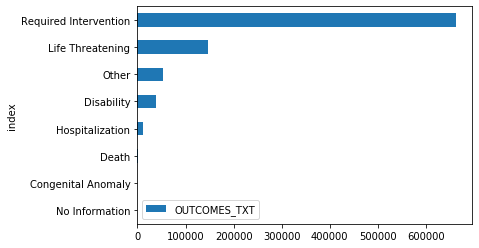

In [106]:
df3[df3.MDR_REPORT_KEY.duplicated()].OUTCOMES_TXT.value_counts(ascending=True).reset_index().plot.barh(x='index', y='OUTCOMES_TXT')

In [111]:
df3.OUTCOMES_TXT.value_counts()

Required Intervention    2352281
Other                    1188134
Hospitalization           754402
Life Threatening          240460
Death                     151993
Disability                 75124
Congenital Anomaly          2838
Invalid Data                 930
Not Applicable               130
No Information                 1
Name: OUTCOMES_TXT, dtype: int64

In [4]:
# 2017, 2018 and 2019 data appended in one dataset.
df.shape

(3338452, 28)

In [5]:
# Preview of the first 5 records
df.head()

,MDR_REPORT_KEY,DEVICE_EVENT_KEY,IMPLANT_FLAG,DATE_REMOVED_FLAG,DEVICE_SEQUENCE_NO,DATE_RECEIVED,BRAND_NAME,GENERIC_NAME,MANUFACTURER_D_NAME,MANUFACTURER_D_ADDRESS_1,MANUFACTURER_D_ADDRESS_2,MANUFACTURER_D_CITY,MANUFACTURER_D_STATE_CODE,MANUFACTURER_D_ZIP_CODE,MANUFACTURER_D_ZIP_CODE_EXT,MANUFACTURER_D_COUNTRY_CODE,MANUFACTURER_D_POSTAL_CODE,EXPIRATION_DATE_OF_DEVICE,MODEL_NUMBER,CATALOG_NUMBER,LOT_NUMBER,OTHER_ID_NUMBER,DEVICE_OPERATOR,DEVICE_AVAILABILITY,DATE_RETURNED_TO_MANUFACTURER,DEVICE_REPORT_PRODUCT_CODE,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR
0,6216912,NaN,NaN,NaN,1,01/01/2017,MERGE HEMODYNAMICS,PROGRAMMABLE DIAGNOSTIC COMPUTER,MERGE HEALTHCARE,900 WALNUT RIDGE DRIVE,NaN,HARTLAND,WI,53029,NaN,US,53029,NaN,MERGE HEMODYNAMICS 10.0.1,NaN,NaN,NaN,0HP,Y,NaN,DQK,DA,R
1,6216913,NaN,NaN,NaN,1,01/01/2017,MERGE HEMODYNAMICS,PROGRAMMABLE DIAGNOSTIC COMPUTER,MERGE HEALTHCARE,900 WALNUT RIDGE DRIVE,NaN,HARTLAND,WI,53029,NaN,US,53029,NaN,MERGE HEMODYNAMICS 10.0.1,NaN,NaN,NaN,0HP,R,02/20/2017,DQK,DA,Y
2,6216914,NaN,NaN,NaN,1,01/01/2017,MERGE UNITY PACS,PICTURE AND ARCHIVING COMMUNICATIONS SYSTEM,MERGE HEALTHCARE,900 WALNUT RIDGE DRIVE,NaN,HARTLAND,WI,53029,NaN,US,53029,NaN,UNITY PACS R10.0.436.121,NaN,NaN,NaN,0HP,Y,NaN,LLZ,DA,Y
3,6216915,NaN,NaN,NaN,1,01/01/2017,OT VERIO FLEX METER,GLUCOSE MONITORING SYS/KIT,"LIFESCAN EUROPE, A DIVISION OF CILAG GMBH INTL",GUBELSTRASSE 34,NaN,ZUG,NaN,6300,NaN,SZ,6300,NaN,NaN,NaN,NaN,1-3BBSA4F,0LP,N,NaN,NBW,NaN,R
4,6216916,NaN,NaN,NaN,1,01/01/2017,OT VERIO2 METER,GLUCOSE MONITORING SYS/KIT,"LIFESCAN EUROPE, A DIVISION OF CILAG GMBH INTL",GUBELSTRASSE 34,NaN,ZUG,NaN,6300,NaN,SZ,6300,NaN,NaN,NaN,4054781,1-2IZSAO8,0LP,N,NaN,NBW,NaN,R


In [6]:
df.columns

Index(['MDR_REPORT_KEY', 'DEVICE_EVENT_KEY', 'IMPLANT_FLAG',
       'DATE_REMOVED_FLAG', 'DEVICE_SEQUENCE_NO', 'DATE_RECEIVED',
       'BRAND_NAME', 'GENERIC_NAME', 'MANUFACTURER_D_NAME',
       'MANUFACTURER_D_ADDRESS_1', 'MANUFACTURER_D_ADDRESS_2',
       'MANUFACTURER_D_CITY', 'MANUFACTURER_D_STATE_CODE',
       'MANUFACTURER_D_ZIP_CODE', 'MANUFACTURER_D_ZIP_CODE_EXT',
       'MANUFACTURER_D_COUNTRY_CODE', 'MANUFACTURER_D_POSTAL_CODE',
       'EXPIRATION_DATE_OF_DEVICE', 'MODEL_NUMBER', 'CATALOG_NUMBER',
       'LOT_NUMBER', 'OTHER_ID_NUMBER', 'DEVICE_OPERATOR',
       'DEVICE_AVAILABILITY', 'DATE_RETURNED_TO_MANUFACTURER',
       'DEVICE_REPORT_PRODUCT_CODE', 'DEVICE_AGE_TEXT',
       'DEVICE_EVALUATED_BY_MANUFACTUR'],
      dtype='object')

In [7]:
for i in df.MANUFACTURER_D_NAME.sort_values().unique():
    print(i)

(LIVANOVA USA, INC. / CYBERONICS)
(UNISENSOR USA) LABORIE MEDICAL TECHNOLOGIES
+1(574)372-5905
.
. DEPUY ORTHOPAEDIC INC, 1818910
0988
1 EDWARDS WAY
1 ST. JUDE MEDICAL DRIVE
1. RUSPAK CORPORATION(MANUFACTURER) 2. BELCHER PHARMACEUTICALS, LLC (PRODUCT HOLDER)
1.RUSPAK CORPORATION(MANUFACTURER) 2. BELCHER PHARMACEUTICALS, LLC (PRODUCT HOLDER)
116 AVENUE DU FORMANS
1219655
1219655 DEPUY-RAYNHAM
1219655 DEPUY-RAYNHAM, A DIV. OF DEPUY
1219655 DEPUY-RAYNHAM, A DIV. OF DEPUY ORTHOPAEDIC
1360 SOUTH LOOP ROAD
1360 SOUTH LOOP ROADABBOTT DIABETES CARE INC
1421QWDQ
1800 PYRAMID PLACE
1818910 DEPUY ORTHOPAEDICS, INC.
195 MCDERMOTT RD
195 MCDERMOTT ROAD
201 SABANETAS INDUSTRIAL PARK
2110420
2182356
21ST CENTURY SCIENTIFIC, INC
2211095
22872 AVENIDA EMPRESA
271 GIBRALTAR DR
3 ENTERPRISE DR #210
3-D MACHINING INC.
3003764610
3003895575 DEPUY FRANCE S.A.S.-SAINT PRIEST
3006356043 JOHNSON & JOHNSON MEDICAL
3006356043 JOHNSON & JOHNSON MEDICAL  DEPUY ¿ SUZH
3576 UNOCAL PLACE
3B MEDICAL INC.
3D SYSTEMS
3H

HALYARD HEALTH, INC.
HALYARD HEALTH, INC. (FORMERLY KIMBERLY CLARK)
HALYARD HEALTH, INC. / AVANOS MEDICAL INC.
HALYARD HEALTH, INC. / AVANOS MEDICAL, INC.
HALYARD HEALTH, INC. / EPIMED INTERNATIONAL, INC.
HALYARD HEALTH, INC..
HALYARD HEALTH, INC./ AVANOS MEDICAL, INC.
HALYARD HEALTH, INC./AVANOS MEDICAL, INC.
HALYARD SALES, LLC
HALYARD, MEDLINE, COOK
HALYARD-AVANOS MEDICAL, INC.
HALYARD/AVANOS MEDICAL (LAB) - IRVINE
HALYARD/AVANOS MEDICAL, INC
HALYARD/AVANOS MEDICAL, INC.
HAMILTON MEDICAL
HAMILTON MEDICAL AG
HAMILTON MEDICAL AG / HAMILTON MEDICAL, INC.
HAMILTON MEDICAL INC.
HAMILTON MEDICAL, INC
HAMILTON MEDICAL, INC.
HAND BIOMECHANICS LAB, INC
HAND BIOMECHANICS LAB, INC.
HANDI MOVE INTERNATIONAL
HANDI-CRAFT CO -SAINT LOUIS
HANDICARE
HANDICARE AB
HANDICARE ACCESSIBILITY UK LTD
HANDICARE STAIRLIFTS B.V
HANDICARE STAIRLIFTS B.V.
HANDICARE USA
HANDICARE USA INC.
HANDICARE USA, INC.
HANDPIECE HEADQUARTERS INC.
HANGZHOU FUYANG HONGWEI METAL
HANGZHOU FUYANG HONGWEI METAL PRODUCT LIMITED COM

SUAFLON PHARMACUETICALS, LTD.
SULLIVAN
SUMMIT INTERNATIONAL MEDICAL TECHNOLOGIES
SUMMIT INTERNATIONAL MEDICAL TECHNOLOGIES, INC
SUMMIT MEDICAL PRODUCTS INC
SUMMIT MEDICAL PRODUCTS, INC
SUMMIT MEDICAL PRODUCTS, INC.
SUMMIT MEDICAL, INC.
SUMMIT TO SEA
SUN CAPSULE
SUN DERMATOLOGY / DUSA PHARMACEUTICALS, INC.
SUN DERMATOLOGY PHARMACEUTICALS / DUSA PHARMACEUTICALS, INC.
SUN NUCLEAR CORPORATION
SUN PHARM INDUSTRIES
SUN PHARMACEUTICAL INDUSTRIES LTD.
SUNBEAM
SUNBEAM PRODUCTS INC.
SUNBEAM PRODUCTS, INC.
SUNBEAM PRODUCTS, INC., DBA JARDEN CONSUMER SOLUTI
SUNBEAM, INC.
SUNEVA
SUNEVA MEDICAL
SUNEVA MEDICAL INC.
SUNEVA MEDICAL, INC.
SUNFLOWER MEDICAL L.L.C.
SUNFLOWER MEDICAL L.L.C. (RAYE'S, INC.)
SUNMARK - TRIVIDA HEALTH
SUNMED
SUNMED HOLDINGS LLC.
SUNMED HOLDINGS, LLC
SUNMED HOLDINGS, LLC.
SUNMED LLC.
SUNMED, LLC
SUNNEX, INC.
SUNNEX, LLC
SUNNYVALE
SUNOPTIC TECHNOLOGIES, LLC
SUNRISE MEDICAL
SUNRISE MEDICAL (US) LLC
SUNRISE MEDICAL PRIVADA MISIONES
SUNRISE MEDICAL PTY LTD.
SUNRISE MEDICAL TECHNOLOG

In [8]:
df.MANUFACTURER_D_NAME.sort_values().unique().shape

(11253,)

In [9]:
from matplotlib import pyplot as plt
% matplotlib

Using matplotlib backend: Qt5Agg


In [10]:
df2 = df.MANUFACTURER_D_NAME.value_counts().reset_index().rename(columns={'index':'COMPANY', 'MANUFACTURER_D_NAME':'COUNT'})

In [11]:
df2.shape

(11252, 2)

In [12]:
df2.iloc[:1000, :]

,COMPANY,COUNT
0,MEDTRONIC PUERTO RICO OPERATIONS CO.,457067
1,"DEXCOM, INC.",402908
2,TANDEM DIABETES CARE,141536
3,INSTITUT STRAUMANN AG,72059
4,MPRI,60720
...,...,...
995,MEDIVATORS INC.,67
996,MEDICAL DEVICES,67
997,ETHICON ENDO-SURGERY,67
998,BOSTON SCIENTIFIC - SAN JOSE,66


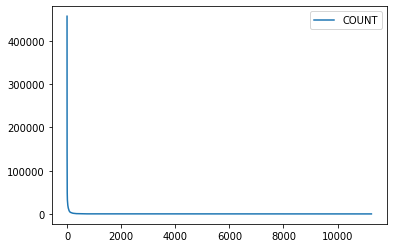

In [21]:
bar = df2.plot()

In [24]:
df.head(100)

,MDR_REPORT_KEY,DEVICE_EVENT_KEY,IMPLANT_FLAG,DATE_REMOVED_FLAG,DEVICE_SEQUENCE_NO,DATE_RECEIVED,BRAND_NAME,GENERIC_NAME,MANUFACTURER_D_NAME,MANUFACTURER_D_ADDRESS_1,MANUFACTURER_D_ADDRESS_2,MANUFACTURER_D_CITY,MANUFACTURER_D_STATE_CODE,MANUFACTURER_D_ZIP_CODE,MANUFACTURER_D_ZIP_CODE_EXT,MANUFACTURER_D_COUNTRY_CODE,MANUFACTURER_D_POSTAL_CODE,EXPIRATION_DATE_OF_DEVICE,MODEL_NUMBER,CATALOG_NUMBER,LOT_NUMBER,OTHER_ID_NUMBER,DEVICE_OPERATOR,DEVICE_AVAILABILITY,DATE_RETURNED_TO_MANUFACTURER,DEVICE_REPORT_PRODUCT_CODE,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR
0,6216912,NaN,NaN,NaN,1,01/01/2017,MERGE HEMODYNAMICS,PROGRAMMABLE DIAGNOSTIC COMPUTER,MERGE HEALTHCARE,900 WALNUT RIDGE DRIVE,NaN,HARTLAND,WI,53029,NaN,US,53029,NaN,MERGE HEMODYNAMICS 10.0.1,NaN,NaN,NaN,0HP,Y,NaN,DQK,DA,R
1,6216913,NaN,NaN,NaN,1,01/01/2017,MERGE HEMODYNAMICS,PROGRAMMABLE DIAGNOSTIC COMPUTER,MERGE HEALTHCARE,900 WALNUT RIDGE DRIVE,NaN,HARTLAND,WI,53029,NaN,US,53029,NaN,MERGE HEMODYNAMICS 10.0.1,NaN,NaN,NaN,0HP,R,02/20/2017,DQK,DA,Y
2,6216914,NaN,NaN,NaN,1,01/01/2017,MERGE UNITY PACS,PICTURE AND ARCHIVING COMMUNICATIONS SYSTEM,MERGE HEALTHCARE,900 WALNUT RIDGE DRIVE,NaN,HARTLAND,WI,53029,NaN,US,53029,NaN,UNITY PACS R10.0.436.121,NaN,NaN,NaN,0HP,Y,NaN,LLZ,DA,Y
3,6216915,NaN,NaN,NaN,1,01/01/2017,OT VERIO FLEX METER,GLUCOSE MONITORING SYS/KIT,"LIFESCAN EUROPE, A DIVISION OF CILAG GMBH INTL",GUBELSTRASSE 34,NaN,ZUG,NaN,6300,NaN,SZ,6300,NaN,NaN,NaN,NaN,1-3BBSA4F,0LP,N,NaN,NBW,NaN,R
4,6216916,NaN,NaN,NaN,1,01/01/2017,OT VERIO2 METER,GLUCOSE MONITORING SYS/KIT,"LIFESCAN EUROPE, A DIVISION OF CILAG GMBH INTL",GUBELSTRASSE 34,NaN,ZUG,NaN,6300,NaN,SZ,6300,NaN,NaN,NaN,4054781,1-2IZSAO8,0LP,N,NaN,NBW,NaN,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6217007,NaN,NaN,NaN,1,01/01/2017,ANIMAS VIBE,INSULIN INFUSION PUMP,ANIMAS CORPORATION,200 LAWRENCE DR,NaN,WEST CHESTER,PA,19380,3428,US,193803428,NaN,NaN,NaN,NaN,1-MCBC-3762,0LP,R,01/12/2017,LZG,39 MO,Y
96,6217008,NaN,NaN,NaN,1,01/01/2017,ANIMAS VIBE,INSULIN INFUSION PUMP,ANIMAS CORPORATION,200 LAWRENCE DR,NaN,WEST CHESTER,PA,19380,3428,US,193803428,NaN,NaN,NaN,NaN,1-MCBC-3762,0LP,R,01/03/2017,LZG,61 MO,Y
97,6217009,NaN,NaN,NaN,1,01/01/2017,OVATION PRIME ABDOMINAL STENT GRAFT SYSTEM,"ENDOVASCULAR GRAFT, ABDOMINAL AORTIC ANEURYSM","TRIVASCULAR, INC.",3910 BRICKWAY BLVD.,NaN,SANTA ROSA,CA,95403,NaN,US,95403,05/15/2018,TV-AB2080-E,TV-AB2080-E,FS022715-06,NaN,001,N,NaN,MIH,NaN,Y
98,6217010,NaN,NaN,NaN,1,01/01/2017,ANIMAS VIBE,INSULIN INFUSION PUMP,ANIMAS CORPORATION,200 LAWRENCE DR,NaN,WEST CHESTER,PA,19380,3428,US,193803428,NaN,NaN,NaN,NaN,NaN,0LP,R,01/06/2017,LZG,DA,R
